# Dynex SDK - Simple Shor Native Gate Circuit Example

First we import the required packages:

In [1]:
import dynex
from dynex import dynex_circuit
from pennylane import numpy as np
import pennylane as qml
import math
from fractions import Fraction

We define our circuit "Shor for Integer Factorization":

In [2]:
# to draw the circuit we can assume N = 35 and a = 12
a = 12
N = 35
params = [N, a]
wires = 10 + int(np.ceil(np.log2(N))) # 10 estimated qubits for computing the period (r) 

def _GetU_NA(a, N):
    nQ = int(np.ceil(np.log2(N)))
    uNA = np.zeros([2 ** nQ, 2 ** nQ])
    for k in range(N):
        uNA[(k * a) % N, k] = 1
    for extra in range(N, 2 ** nQ):
        uNA[extra, extra] = 1
    return uNA

def ShorsCircuit(params):
    N, a = int(params[0]), int(params[1])
    uNA = _GetU_NA(a, N)
    nEstimateQUBITS = 10
    nTargetQUBITS = int(np.ceil(np.log2(N)))
    tQ = nEstimateQUBITS + nTargetQUBITS
    estWIRES = range(nEstimateQUBITS)
    tWAIRES = range(nEstimateQUBITS, tQ)
    qml.PauliX(wires=tWAIRES[-1])
    for wire in estWIRES:
        qml.Hadamard(wires=wire)
    for i, wire in enumerate(estWIRES):
        power = 2 ** (nEstimateQUBITS - i - 1)
        qml.ControlledQubitUnitary(qml.math.linalg.matrix_power(uNA, power), 
                                   control_wires=[wire], 
                                   wires=tWAIRES)
    qml.adjoint(qml.QFT)(wires=estWIRES)
    return qml.sample()

def Fraction2Float(sample):
    return np.sum([int(sample[bit]) / 2 ** (bit + 1) for bit in range(len(sample))])

def Phase2Order(phase, max_denominator):
    sR = Fraction(phase)
    order = sR.limit_denominator(max_denominator).denominator
    if order % 2 == 0:
        return order
    else:
        return order + 1 # get only even Period (correction)

We draw the circuit:

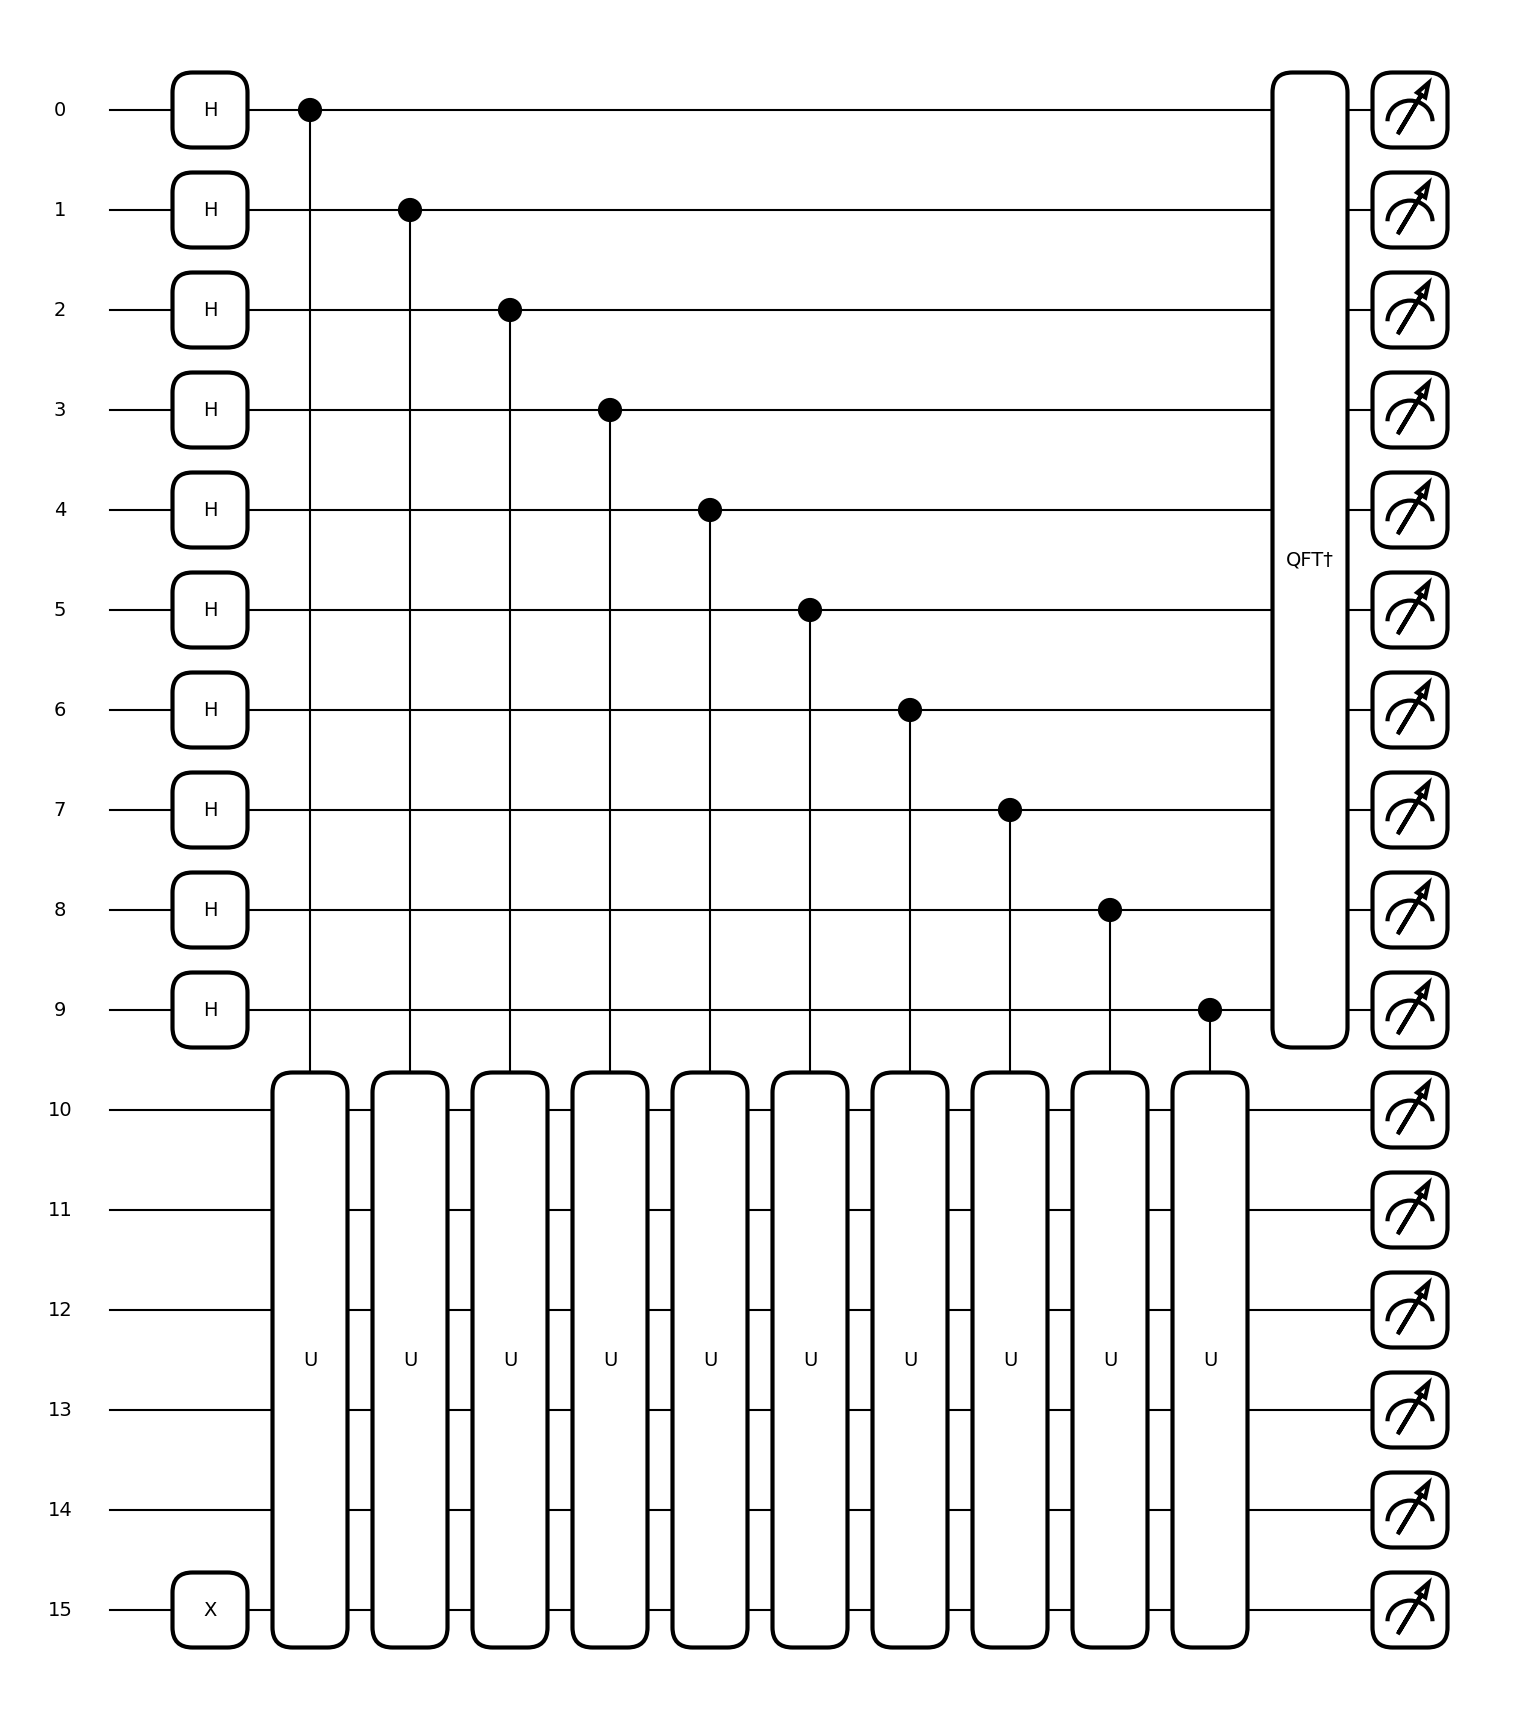

In [3]:
# draw circuit:
_ = qml.draw_mpl(ShorsCircuit, style="black_white")(params)

We execute and measure the circuit on the Dynex platform:

In [4]:
def SimpleShorsAlgo(N):
    max_its = 10
    for _ in range(max_its):
        a = np.random.choice(list(range(2, N - 1)))
        print(f"Chose a={a}")
        params = [N, a]
        wires = 10 + int(np.ceil(np.log2(N)))
        solutions = dynex_circuit.execute(ShorsCircuit, params, wires, method='all', num_reads=1000, 
                                 integration_steps=100, debugging=False, mainnet=True, shots=7)
        for solution in solutions:
            solution_array = np.array(solution)
            estimated_bits = solution_array[-10:]  # Take the estimated qubits ONLY `nEstimateQUBITS`
            phase = Fraction2Float(estimated_bits)
            r = Phase2Order(phase, N)
            x = a ** (r // 2) % N
            if x == 1 or x == N - 1:
                continue
            p = np.gcd(x - 1, N)
            q = np.gcd(x + 1, N)
            if p * q == N:
                print(f"Found solution:")
                print(f"r = {r}, x = {x}")
                print(f"p = {p}, q = {q}")
                return p, q
    print("No solution found after maximum iterations. (We need to find proper way for the `a`)")
    return None, None

N = 35
p, q = SimpleShorsAlgo(N)
print(f"Factorization of {N}: {p} and {q}")

╭────────────┬──────────┬─────────────────┬─────────────┬───────────┬────────────────┬────────────┬─────────┬────────────────╮
│   DYNEXJOB │   QUBITS │   QUANTUM GATES │   BLOCK FEE │   ELAPSED │   WORKERS READ │   CIRCUITS │   STEPS │   GROUND STATE │
├────────────┼──────────┼─────────────────┼─────────────┼───────────┼────────────────┼────────────┼─────────┼────────────────┤
│      29851 │      160 │             884 │        0.00 │      0.98 │              7 │       7000 │     100 │      335832.00 │
╰────────────┴──────────┴─────────────────┴─────────────┴───────────┴────────────────┴────────────┴─────────┴────────────────╯
╭────────────┬─────────────────┬────────────┬───────┬──────────┬───────────────┬─────────────────────────────┬───────────┬──────────╮
│     WORKER │         VERSION │   CIRCUITS │   LOC │   ENERGY │       RUNTIME │                 LAST UPDATE │     STEPS │   STATUS │
├────────────┼─────────────────┼────────────┼───────┼──────────┼───────────────┼─────────────────